In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df=pd.read_csv('EDA_Data_1.csv', index_col=0)

<ipython-input-1-342cdba8183e>:5: DtypeWarning: Columns (131) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('EDA_Data_1.csv', index_col=0)


- đánh giá số lượng nhãn
- đánh giá một số đặc trưng quan trọng theo nhãn
- đánh giá một số đặc trưng biến đổi theo nhãn
- đánh giá tương quan của một số đặc trưng đặc biệt
- đánh giá theo ngày


## 1. Ngày

In [2]:
from datetime import datetime
current_date = datetime.strptime('2024-10-01',"%Y-%m-%d")
df['super_period_expiry_date'] = pd.to_datetime(df['super_period_expiry_date'], format='%m/%d/%Y', errors='coerce')
df['service_fee_expiry_date'] = pd.to_datetime(df['service_fee_expiry_date'], format='%m/%d/%Y', errors='coerce')
df['account_disconnection_date'] = pd.to_datetime(df['account_disconnection_date'], format='%m/%d/%Y', errors='coerce')

df['interval_tolock'] = df['super_period_expiry_date'].apply(
    lambda x: (x-current_date ).days if pd.notnull(x) else 0
)

df['interval_topay'] = df['service_fee_expiry_date'].apply(
    lambda x: (x-current_date ).days if pd.notnull(x) else 0
)

df['interval_tocancel'] = df['account_disconnection_date'].apply(
    lambda x: (x-current_date ).days if pd.notnull(x) else 0
)

df['ACTVTN_DT'] = pd.to_datetime(df['ACTVTN_DT'], format='%Y%m%d', errors='coerce')

df['interval_activate'] = df['ACTVTN_DT'].apply(
    lambda x: (current_date - x).days if pd.notnull(x) else 0
)


In [3]:
min_date = df['ACTVTN_DT'].min()
max_date = df['ACTVTN_DT'].max()

print("Minimum activation date:", min_date)
print("Maximum activation date:", max_date)

Minimum activation date: 1999-01-01 00:00:00
Maximum activation date: 2024-07-31 00:00:00


In [4]:
min_date = df['super_period_expiry_date'].min()
max_date = df['super_period_expiry_date'].max()

print("Minimum activation date:", min_date)
print("Maximum activation date:", max_date)

Minimum activation date: 2017-08-05 00:00:00
Maximum activation date: 2038-01-18 00:00:00


In [5]:
min_date = df['service_fee_expiry_date'].min()
max_date = df['service_fee_expiry_date'].max()

print("Minimum activation date:", min_date)
print("Maximum activation date:", max_date)

Minimum activation date: 2024-07-02 00:00:00
Maximum activation date: 2038-01-18 00:00:00


In [6]:
min_date = df['account_disconnection_date'].min()
max_date = df['account_disconnection_date'].max()

print("Minimum activation date:", min_date)
print("Maximum activation date:", max_date)

Minimum activation date: 2024-08-31 00:00:00
Maximum activation date: 2038-02-27 00:00:00


### 1.1 Số ngày kể từ khi kích hoạt SIM

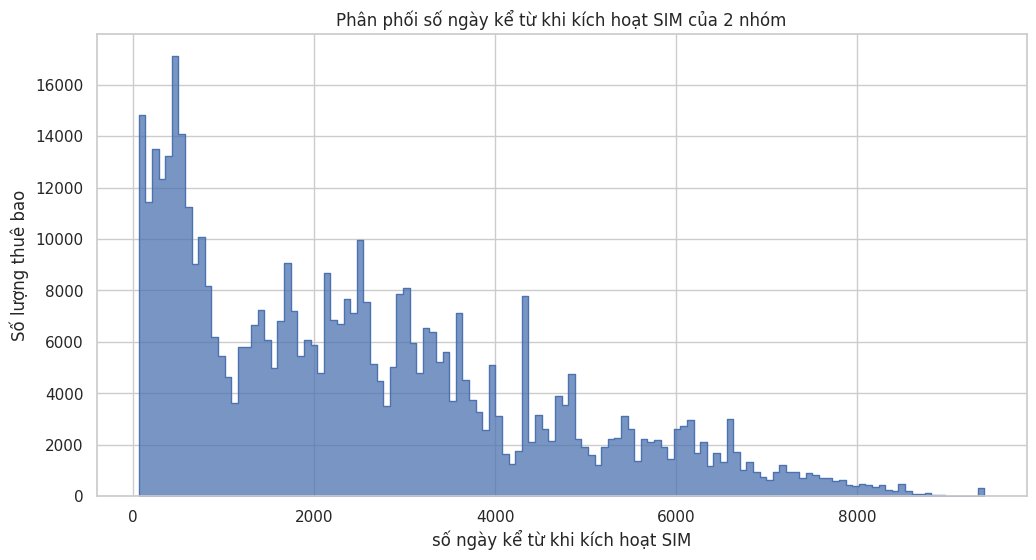

In [7]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='interval_activate', kde=False, element="step", stat="count", common_norm=False)

plt.title("Phân phối số ngày kể từ khi kích hoạt SIM của 2 nhóm")
plt.xlabel("số ngày kể từ khi kích hoạt SIM")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

In [8]:
df['interval_activate'].describe()

,interval_activate
count,497282.000000
mean,2544.112771
std,1979.151626
min,62.000000
25%,772.000000
50%,2209.000000
75%,3666.000000
max,9405.000000


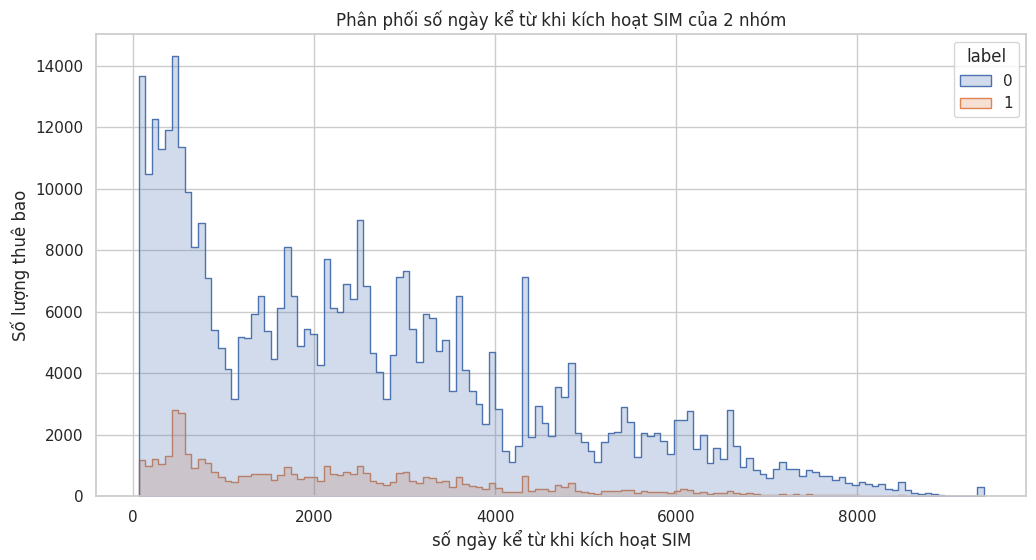

In [9]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='interval_activate', hue='label', kde=False, element="step", stat="count", common_norm=False)

plt.title("Phân phối số ngày kể từ khi kích hoạt SIM của 2 nhóm")
plt.xlabel("số ngày kể từ khi kích hoạt SIM")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()


In [10]:
df_buy=df[(df['label']==1)]
df_churn=df[(df['label']==0)]

In [11]:
df_buy['interval_activate'].describe()

,interval_activate
count,49384.000000
mean,2218.994816
std,1800.039518
min,62.000000
25%,628.000000
50%,1831.000000
75%,3235.000000
max,9405.000000


In [12]:
df_churn['interval_activate'].describe()

,interval_activate
count,447898.000000
mean,2579.959381
std,1994.678466
min,62.000000
25%,789.000000
50%,2252.000000
75%,3727.000000
max,9405.000000


- Ở nhóm mua thì đỉnh phân phối nằm ở khoảng 300-500 ngày
- Ở nhóm không mua thì đỉnh (0,200) ngày cũng xuất hiện nhiều.
- Số ngày càng lớn thì 2 phân phối giảm dần về số lượng thuê bao.

### 1.2 Số ngày cho đến lúc phải trả phí

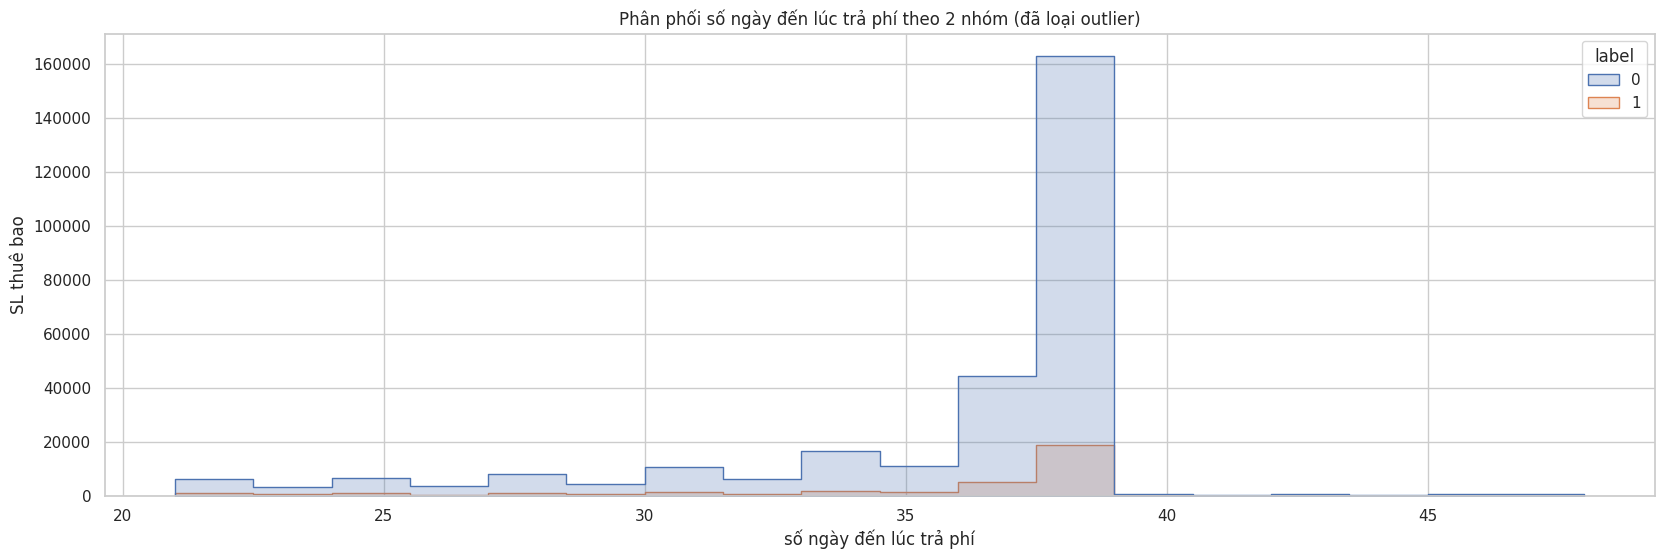

In [13]:
Q1 = df['interval_topay'].quantile(0.25)
Q3 = df['interval_topay'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['interval_topay'] >= lower_bound) & (df['interval_topay'] <= upper_bound)]

bin_width = 2  # Adjust bin width for smoother distribution
num_bins = int((df_filtered['interval_topay'].max() - df_filtered['interval_tolock'].min()) / bin_width)

plt.figure(figsize=(20, 6))
sns.histplot(data=df_filtered, x='interval_topay', hue='label', kde=False, element="step", stat="count",bins=num_bins, common_norm=False)

plt.title("Phân phối số ngày đến lúc trả phí theo 2 nhóm (đã loại outlier)")
plt.xlabel("số ngày đến lúc trả phí")
plt.ylabel("SL thuê bao")

# Show the plot
plt.show()

Phân phối 2 nhóm có sự tương đồng nhau, tuy nhiên, đỉnh của nhóm không mua chiếm tỉ lệ lớn so với nhóm mua

### 1.3 Số ngày cho đến lúc SIM bị hủy


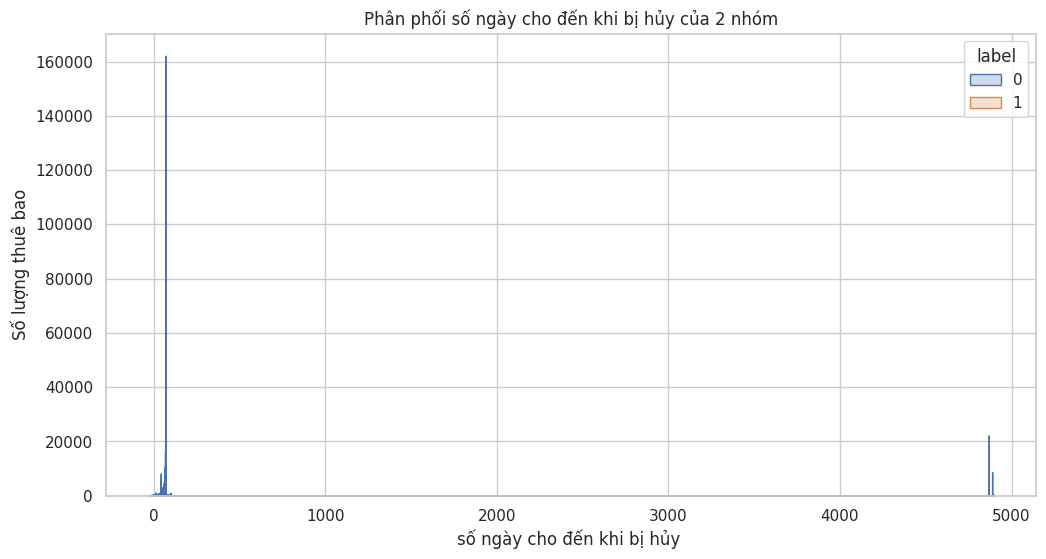

In [14]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='interval_tocancel', hue='label', kde=False, element="step", stat="count", common_norm=False)

plt.title("Phân phối số ngày cho đến khi bị hủy của 2 nhóm")
plt.xlabel("số ngày cho đến khi bị hủy ")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

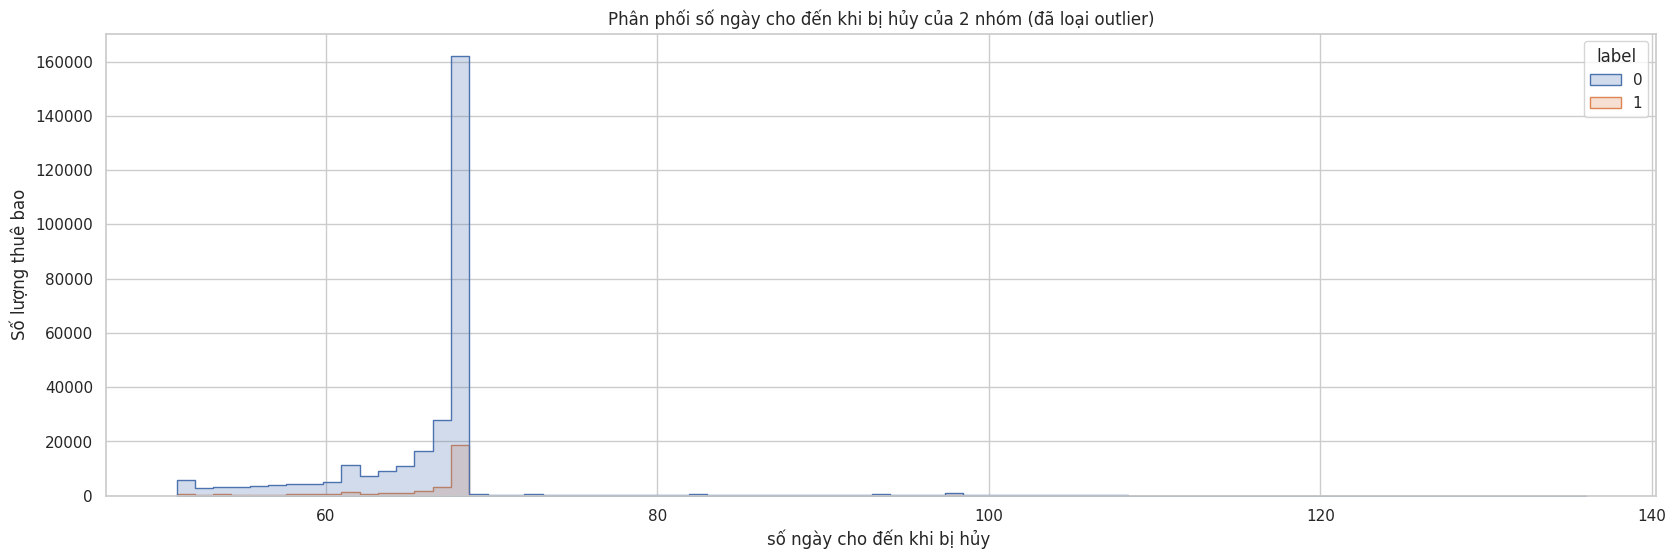

In [15]:
Q1 = df['interval_tocancel'].quantile(0.25)
Q3 = df['interval_tocancel'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['interval_tocancel'] >= lower_bound) & (df['interval_topay'] <= upper_bound)]

bin_width = 2  # Adjust bin width for smoother distribution
num_bins = int((df_filtered['interval_tocancel'].max() - df_filtered['interval_tolock'].min()) / bin_width)

plt.figure(figsize=(20, 6))
sns.histplot(data=df_filtered, x='interval_tocancel', hue='label', kde=False, element="step", stat="count",bins=num_bins, common_norm=False)

plt.title("Phân phối số ngày cho đến khi bị hủy của 2 nhóm (đã loại outlier)")
plt.xlabel("số ngày cho đến khi bị hủy ")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

### 1.3 Số ngày cho đến lúc SIM bị khóa

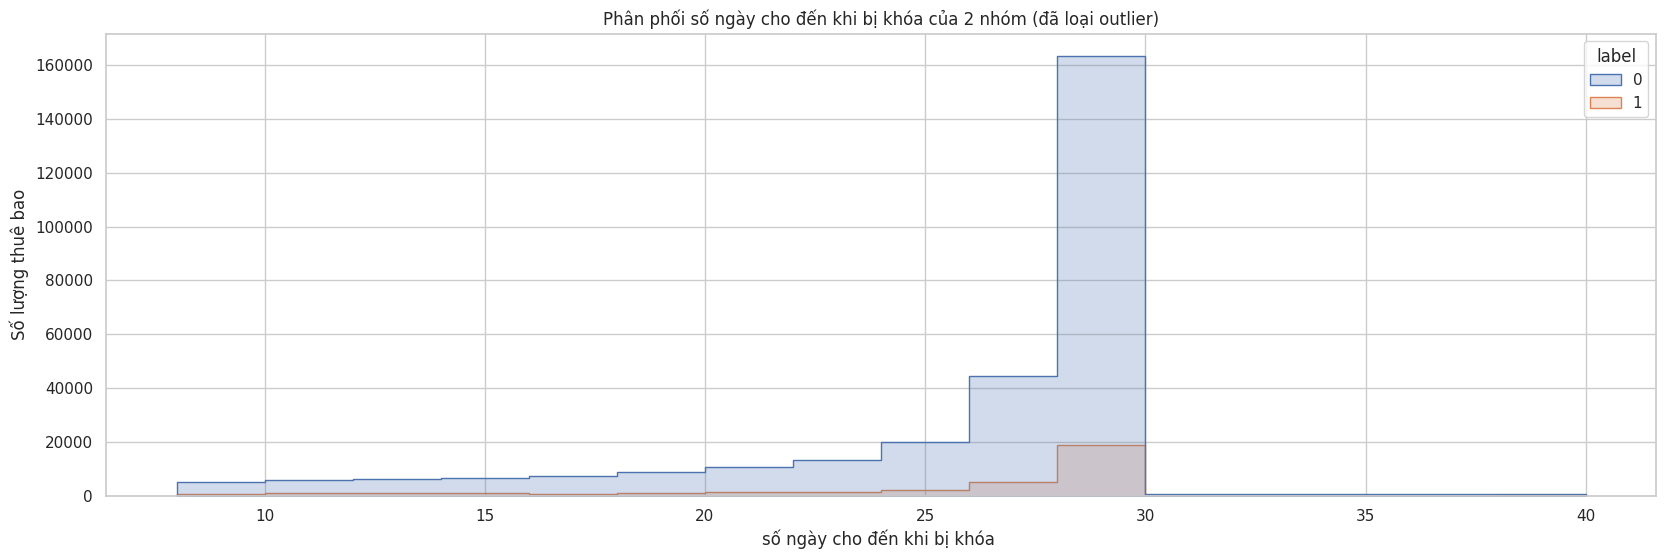

In [16]:
Q1 = df['interval_tolock'].quantile(0.25)
Q3 = df['interval_tolock'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['interval_tolock'] >= lower_bound) & (df['interval_tolock'] <= upper_bound)]

bin_width = 2  # Adjust bin width for smoother distribution
num_bins = int((df_filtered['interval_tolock'].max() - df_filtered['interval_tolock'].min()) / bin_width)

plt.figure(figsize=(20, 6))
sns.histplot(data=df_filtered, x='interval_tolock', hue='label', kde=False, element="step", stat="count",bins=num_bins, common_norm=False)

plt.title("Phân phối số ngày cho đến khi bị khóa của 2 nhóm (đã loại outlier)")
plt.xlabel("số ngày cho đến khi bị khóa ")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

In [17]:
df_churn['interval_tolock'].describe()

,interval_tolock
count,447898.000000
mean,451.335154
std,1243.240112
min,-2614.000000
25%,20.000000
50%,28.000000
75%,28.000000
max,4857.000000


In [18]:
df_buy['interval_tolock'].describe()

,interval_tolock
count,49384.000000
mean,369.919286
std,1118.795075
min,-660.000000
25%,19.000000
50%,28.000000
75%,28.000000
max,4857.000000


## 2. Thông tin nhân khẩu học

### 2.1 Giới tính

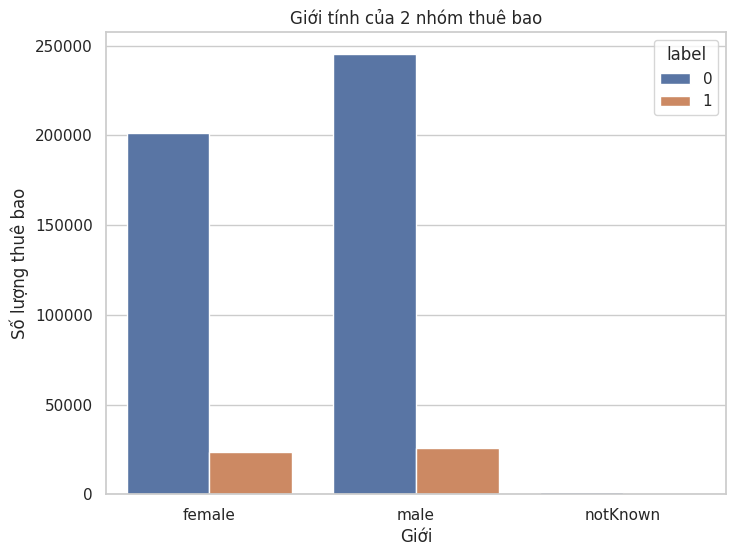

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='gender', hue='label')

plt.title("Giới tính của 2 nhóm thuê bao")
plt.xlabel("Giới")
plt.ylabel("Số lượng thuê bao")

plt.show()

### 2.2 Tuổi

In [20]:
df['tuoi'] = df['tuoi'].replace('notKnown', '300')
df['tuoi'] = pd.to_numeric(df['tuoi'], errors='coerce')
df['tuoi'] = df['tuoi'].fillna(300).astype(int)

# Calculate the mean of 'tuoi' excluding values equal to 2024
mean_tuoi = df.loc[df['tuoi'] != 2024, 'tuoi'].mean()

# Replace values equal to 2024 with the calculated mean
df['tuoi'] = df['tuoi'].replace(2024, mean_tuoi)
df['tuoi'] = df['tuoi'].replace(300, mean_tuoi)
df['tuoi'] = df['tuoi'].replace(1065, mean_tuoi)

In [21]:
df['tuoi'].describe()

,tuoi
count,497282.000000
mean,43.530232
std,15.059733
min,3.000000
25%,33.000000
50%,42.000000
75%,54.000000
max,949.000000


In [22]:
df[df['tuoi']==1065]

,ACCS_MTHD_KEY,ACTVTN_DT,ACC,SIM_TYPE,TRANG_THAI,PROVINCE_CODE,PBH,GEO_CITY_NAME,GEO_CNTY_NAME,CD_2G,...,tuoi,gender,service_fee_expiry_date,super_period_expiry_date,account_disconnection_date,label,interval_tolock,interval_topay,interval_tocancel,interval_activate


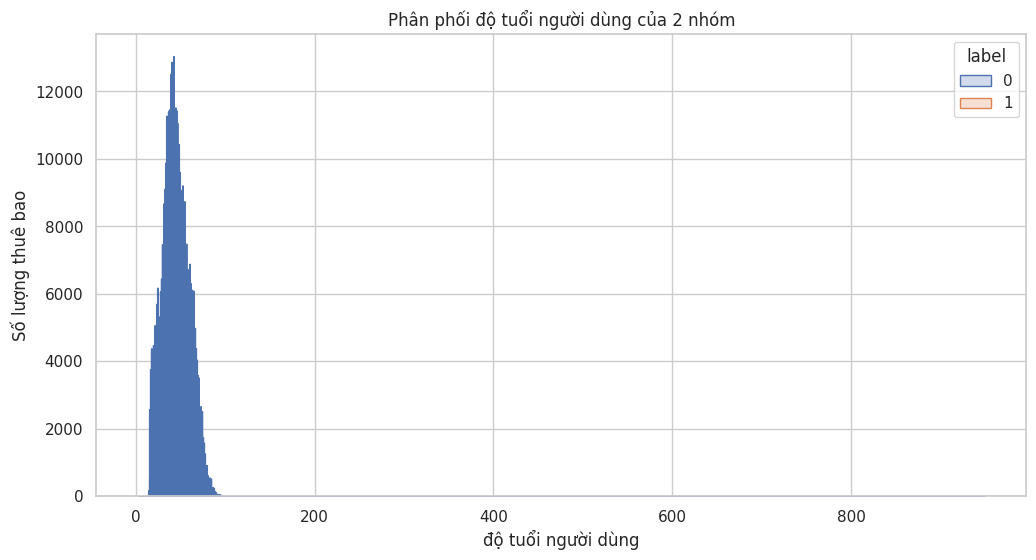

In [23]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='tuoi', hue='label', kde=False, element="step", stat="count", common_norm=False)

plt.title("Phân phối độ tuổi người dùng của 2 nhóm")
plt.xlabel("độ tuổi người dùng")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

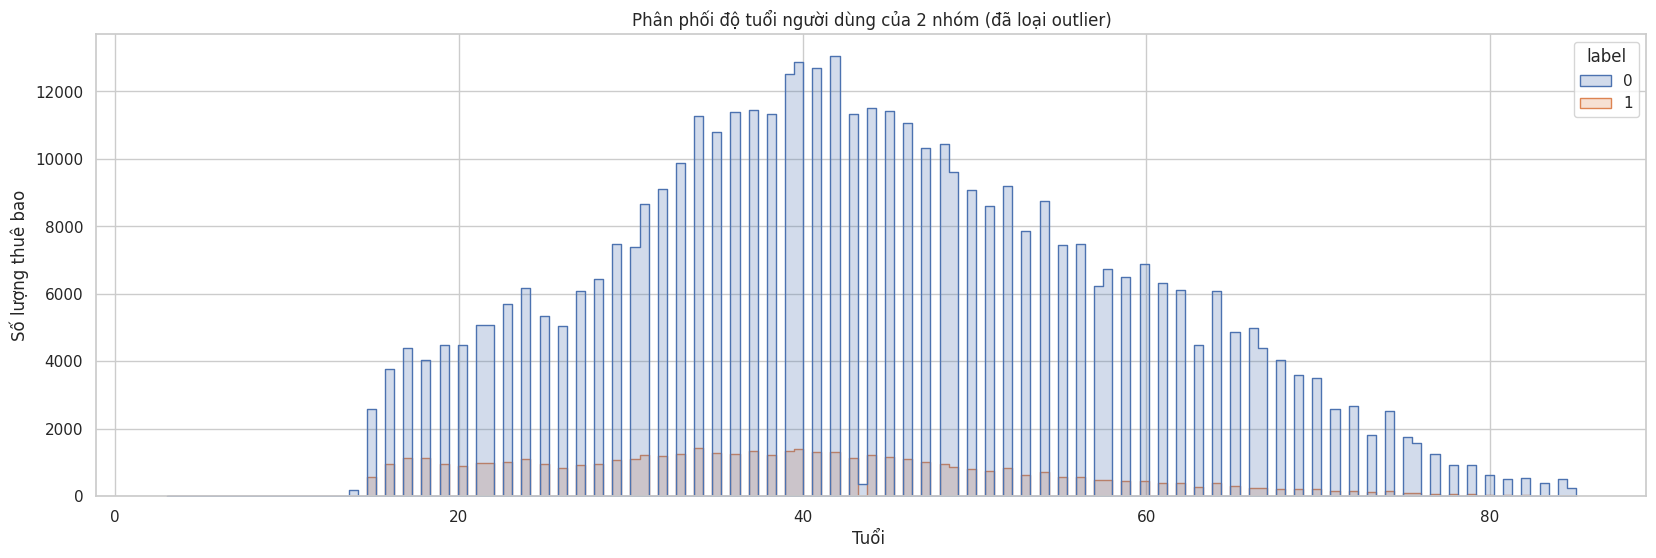

In [24]:
Q1 = df['tuoi'].quantile(0.25)
Q3 = df['tuoi'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['tuoi'] >= lower_bound) & (df['tuoi'] <= upper_bound)]

# bin_width = 2  # Adjust bin width for smoother distribution
# num_bins = int((df_filtered['interval_tocancel'].max() - df_filtered['interval_tolock'].min()) / bin_width)

plt.figure(figsize=(20, 6))
sns.histplot(data=df_filtered, x='tuoi', hue='label', kde=False, element="step", stat="count", common_norm=False)

plt.title("Phân phối độ tuổi người dùng của 2 nhóm (đã loại outlier)")
plt.xlabel("Tuổi ")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

## 3. Đặc trưng liên quan đến tiền


### 3.1 TKC_DATA_T

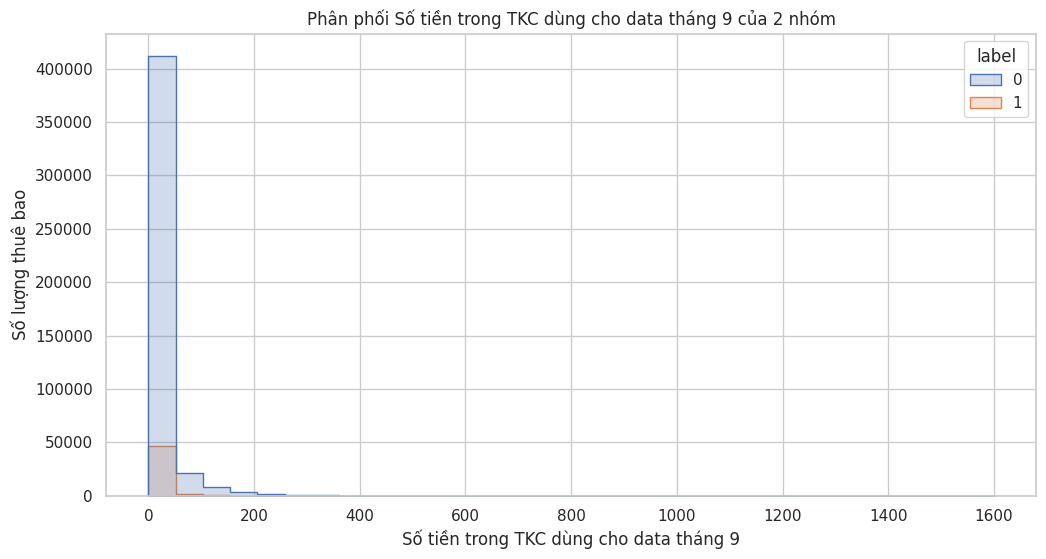

In [25]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

bin_width = 50  # Adjust bin width for smoother distribution
num_bins = int((df_filtered['TKC_DATA_T'].max() - df_filtered['TKC_DATA_T'].min()) / bin_width)

sns.histplot(data=df, x='TKC_DATA_T', hue='label', kde=False, element="step", stat="count", bins=num_bins, common_norm=False)

plt.title("Phân phối Số tiền trong TKC dùng cho data tháng 9 của 2 nhóm")
plt.xlabel("Số tiền trong TKC dùng cho data tháng 9")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

In [26]:
df_churn['TKC_DATA_T'].describe()

,TKC_DATA_T
count,447898.000000
mean,14.187286
std,38.334093
min,0.000000
25%,0.000000
50%,0.300000
75%,8.091100
max,1599.875001


In [27]:
df_buy['TKC_DATA_T'].describe()

,TKC_DATA_T
count,49384.000000
mean,9.951977
std,26.777811
min,0.000000
25%,0.000000
50%,0.900000
75%,7.200000
max,735.000000


### 3.2 TKC_MYTV_T

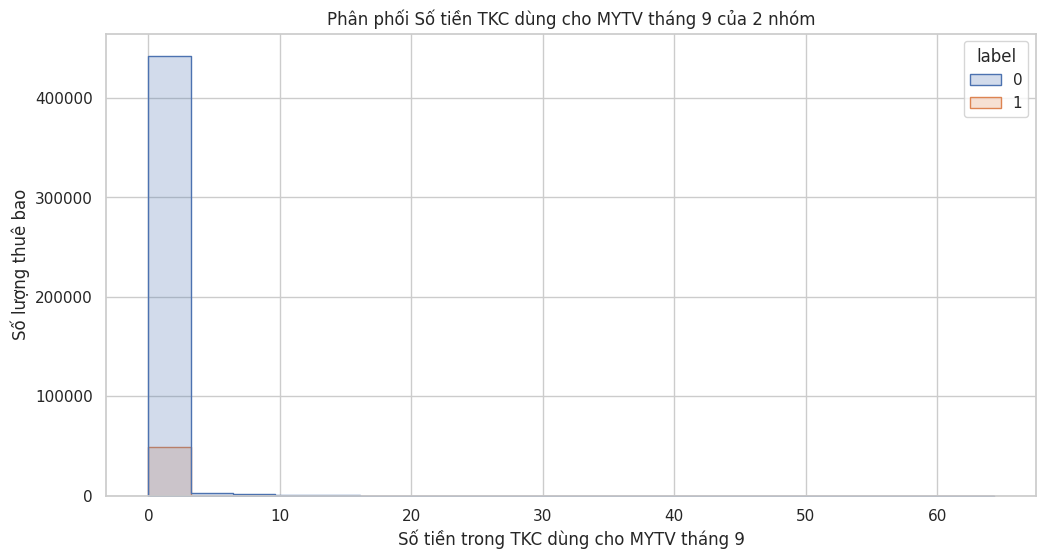

In [28]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='TKC_MYTV_T', hue='label', kde=False, element="step", stat="count", common_norm=False)

plt.title("Phân phối Số tiền TKC dùng cho MYTV tháng 9 của 2 nhóm")
plt.xlabel("Số tiền trong TKC dùng cho MYTV tháng 9")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

### 3.3 TKC_SMS_T

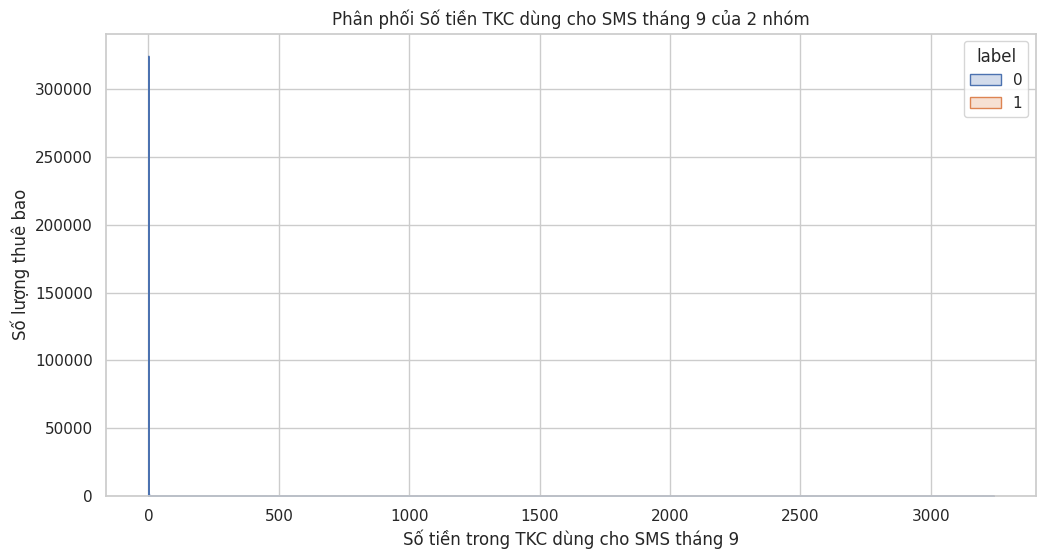

In [29]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='TKC_SMS_T', hue='label', kde=False, element="step", stat="count", common_norm=False)

plt.title("Phân phối Số tiền TKC dùng cho SMS tháng 9 của 2 nhóm")
plt.xlabel("Số tiền trong TKC dùng cho SMS tháng 9")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

In [30]:
df['TKC_SMS_T'].describe()

,TKC_SMS_T
count,497282.000000
mean,1.110922
std,19.516186
min,0.000000
25%,0.000000
50%,0.000000
75%,0.250000
max,3241.359000


### 3.4 TKC_SMS_T_2

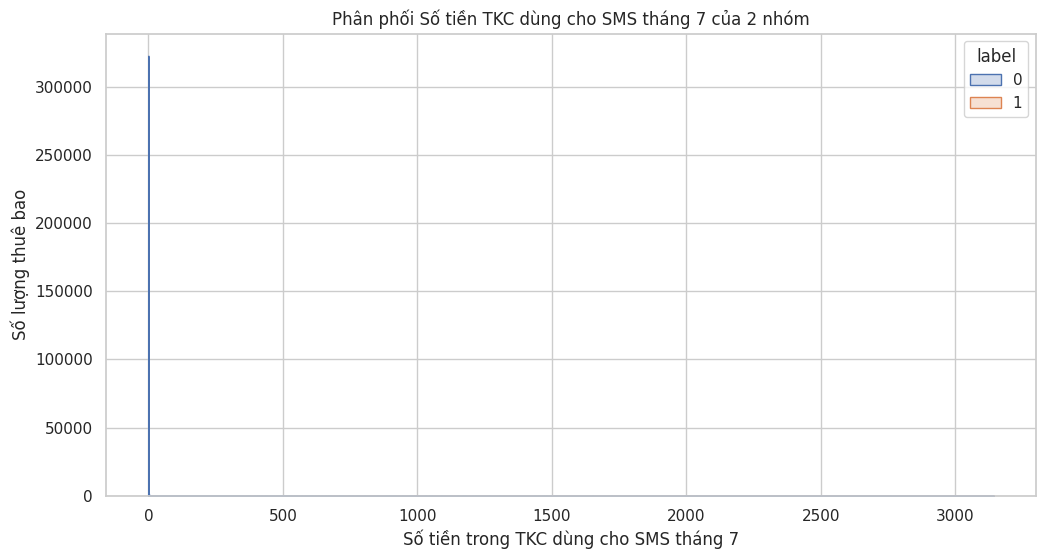

In [31]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='TKC_SMS_T_2', hue='label', kde=False, element="step", stat="count", common_norm=False)

plt.title("Phân phối Số tiền TKC dùng cho SMS tháng 7 của 2 nhóm")
plt.xlabel("Số tiền trong TKC dùng cho SMS tháng 7")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

### 3.5 TKC_MY_TV_T_2

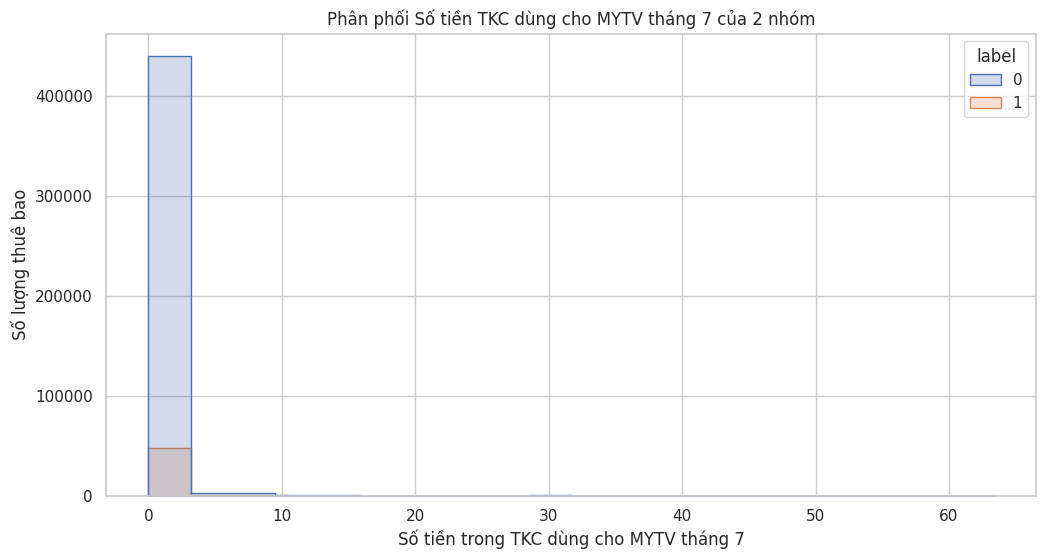

In [32]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='TKC_MYTV_T_2', hue='label', kde=False, element="step", stat="count", common_norm=False)

plt.title("Phân phối Số tiền TKC dùng cho MYTV tháng 7 của 2 nhóm")
plt.xlabel("Số tiền trong TKC dùng cho MYTV tháng 7")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

### 3.6 TKC_DATA_T_2

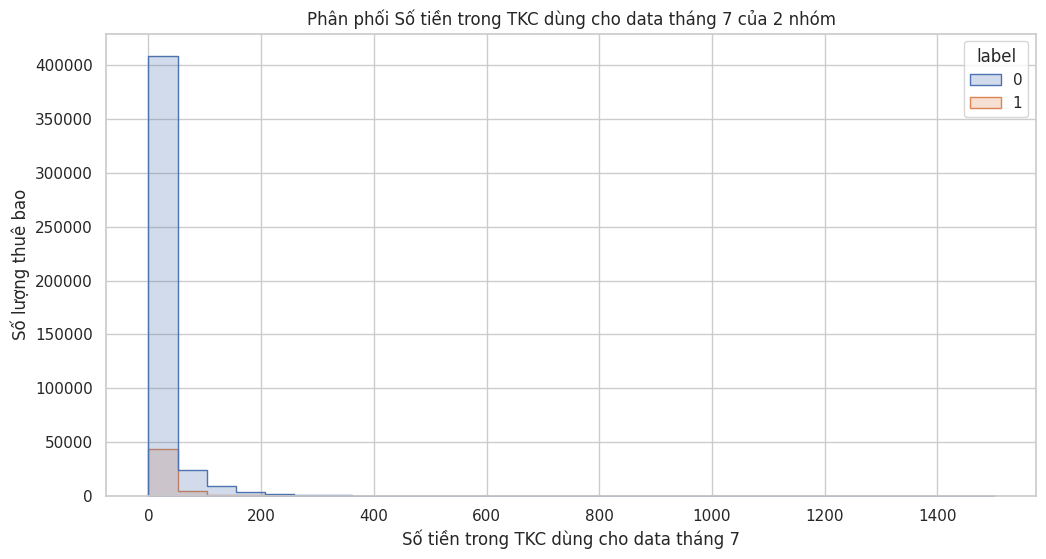

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

bin_width = 50 
num_bins = int((df_filtered['TKC_DATA_T_2'].max() - df_filtered['TKC_DATA_T_2'].min()) / bin_width)

sns.histplot(data=df, x='TKC_DATA_T_2', hue='label', kde=False, element="step", stat="count", bins=num_bins, common_norm=False)

plt.title("Phân phối Số tiền trong TKC dùng cho data tháng 7 của 2 nhóm")
plt.xlabel("Số tiền trong TKC dùng cho data tháng 7")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

### 3.7 TKC_THOAI_T

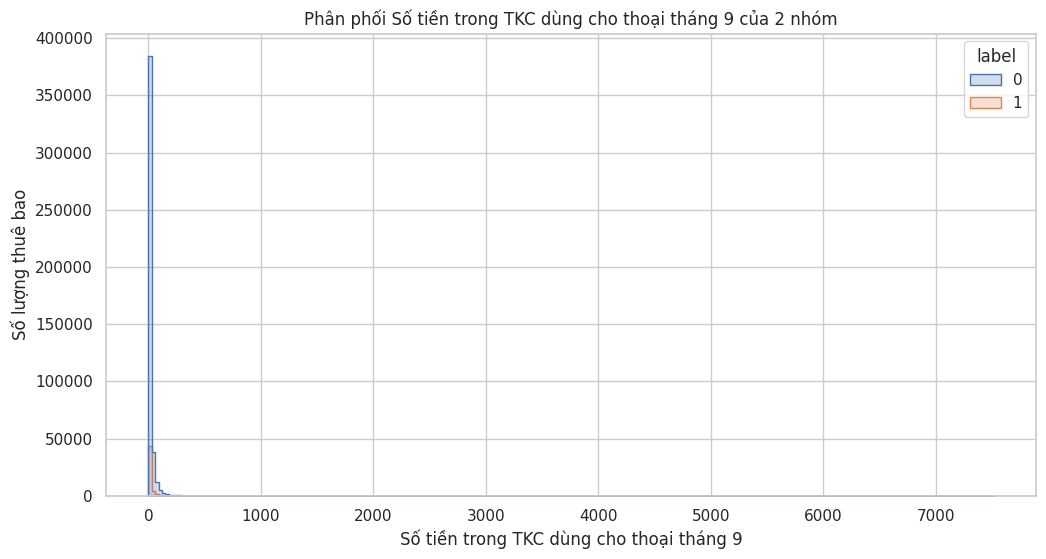

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

bin_width = 30
num_bins = int((df['TKC_THOAI_T'].max() - df['TKC_THOAI_T'].min()) / bin_width)

sns.histplot(data=df, x='TKC_THOAI_T', hue='label', kde=False, element="step", stat="count", bins=num_bins, common_norm=False)

plt.title("Phân phối Số tiền trong TKC dùng cho thoại tháng 9 của 2 nhóm")
plt.xlabel("Số tiền trong TKC dùng cho thoại tháng 9")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

In [35]:
df_buy['TKC_THOAI_T'].describe()

,TKC_THOAI_T
count,49384.000000
mean,12.138710
std,30.487320
min,0.000000
25%,0.000000
50%,1.656000
75%,12.354972
max,1875.634480


In [36]:
df_churn['TKC_THOAI_T'].describe()

,TKC_THOAI_T
count,447898.000000
mean,14.611086
std,40.073551
min,-0.075000
25%,0.000000
50%,2.277000
75%,15.096900
max,7518.000000


### 3.8 TKC_THOAI_T_2

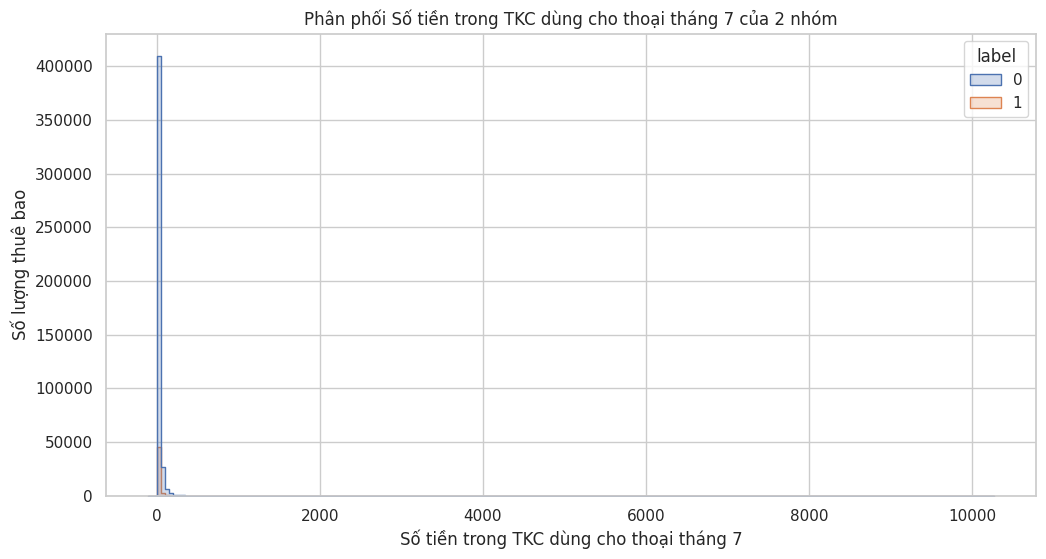

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

bin_width = 50  
num_bins = int((df['TKC_THOAI_T_2'].max() - df['TKC_THOAI_T_2'].min()) / bin_width)

sns.histplot(data=df, x='TKC_THOAI_T_2', hue='label', kde=False, element="step", stat="count", bins=num_bins, common_norm=False)

plt.title("Phân phối Số tiền trong TKC dùng cho thoại tháng 7 của 2 nhóm")
plt.xlabel("Số tiền trong TKC dùng cho thoại tháng 7")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

### 3.9 TKC_T

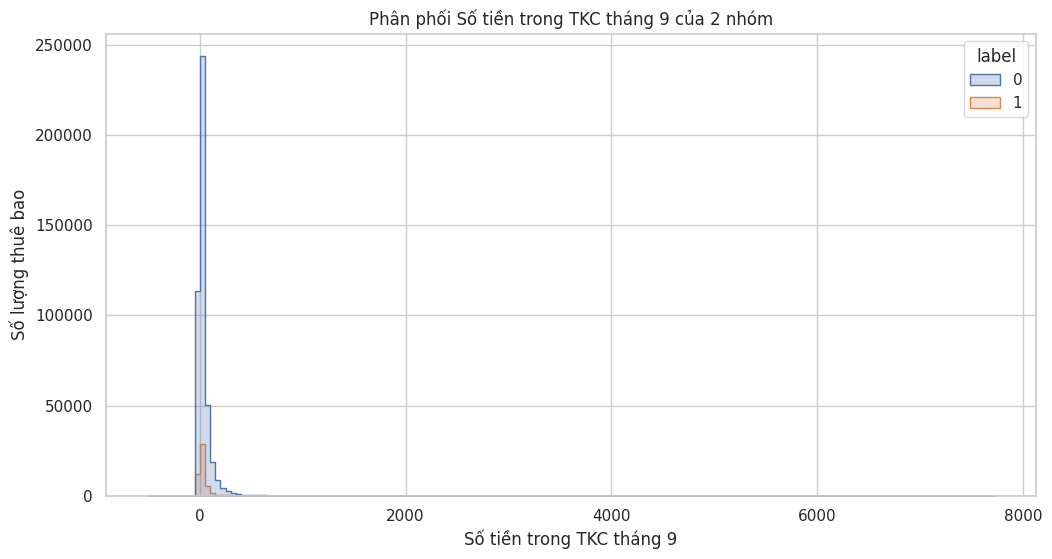

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

bin_width = 50 
num_bins = int((df['TKC_T'].max() - df['TKC_T'].min()) / bin_width)

sns.histplot(data=df, x='TKC_T', hue='label', kde=False, element="step", stat="count", bins=num_bins, common_norm=False)

plt.title("Phân phối Số tiền trong TKC tháng 9 của 2 nhóm")
plt.xlabel("Số tiền trong TKC tháng 9")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

In [39]:
df['TKC_T'].describe()

,TKC_T
count,497282.000000
mean,35.664653
std,78.779993
min,-499.999500
25%,0.928000
50%,12.234895
75%,41.942868
max,7716.000000


In [40]:
df_buy['TKC_T'].describe()

,TKC_T
count,49384.000000
mean,30.510395
std,64.732584
min,0.000000
25%,1.000000
50%,11.533350
75%,38.750000
max,4423.430000


In [41]:
df_churn['TKC_T'].describe()

,TKC_T
count,447898.000000
mean,36.232947
std,80.158103
min,-499.999500
25%,0.900000
50%,12.325000
75%,42.414820
max,7716.000000


### 3.10 TKC_T_2

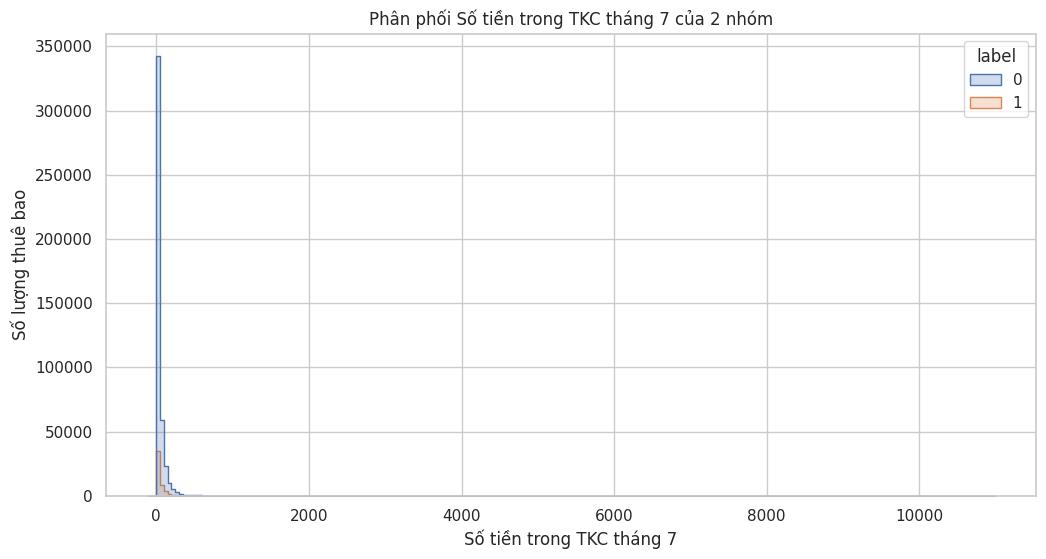

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

bin_width = 50 
num_bins = int((df['TKC_T_2'].max() - df['TKC_T_2'].min()) / bin_width)

sns.histplot(data=df, x='TKC_T_2', hue='label', kde=False, element="step", stat="count", bins=num_bins, common_norm=False)

plt.title("Phân phối Số tiền trong TKC tháng 7 của 2 nhóm")
plt.xlabel("Số tiền trong TKC tháng 7")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

### 3.11 TKC_THOAI_ONNET_T

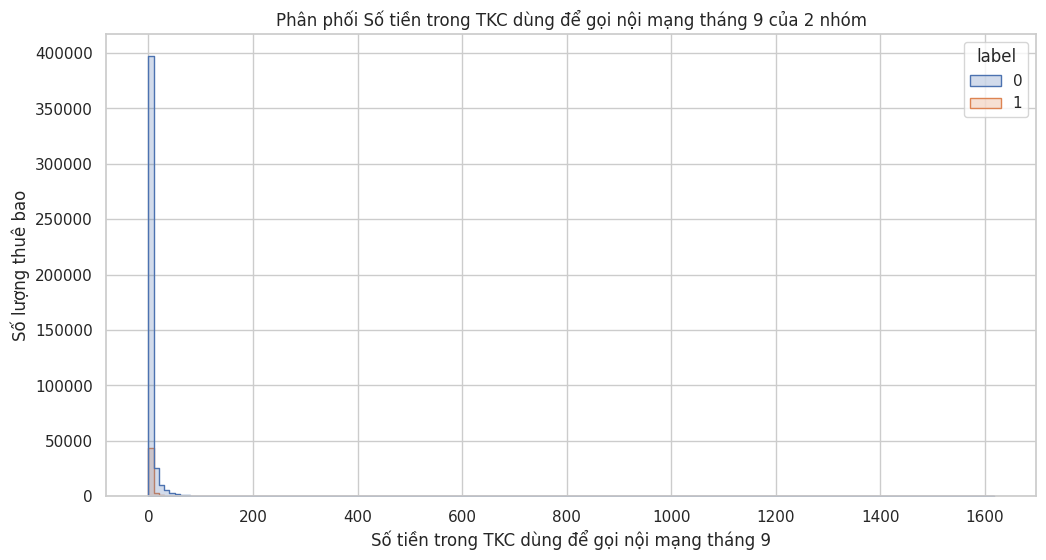

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

bin_width = 10 
num_bins = int((df['TKC_THOAI_ONNET_T'].max() - df['TKC_THOAI_ONNET_T'].min()) / bin_width)

sns.histplot(data=df, x='TKC_THOAI_ONNET_T', hue='label', kde=False, element="step", stat="count", bins=num_bins, common_norm=False)

plt.title("Phân phối Số tiền trong TKC dùng để gọi nội mạng tháng 9 của 2 nhóm")
plt.xlabel("Số tiền trong TKC dùng để gọi nội mạng tháng 9")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

In [44]:
df['TKC_THOAI_T'].describe()

,TKC_THOAI_T
count,497282.000000
mean,14.365560
std,39.233418
min,-0.075000
25%,0.000000
50%,2.199670
75%,14.846030
max,7518.000000


In [45]:
df['TKC_THOAI_ONNET_T'].describe()

,TKC_THOAI_ONNET_T
count,497282.000000
mean,4.349946
std,14.665864
min,0.000000
25%,0.000000
50%,0.000000
75%,2.674080
max,1616.774560


In [46]:
df['TKC_THOAI_OFFNET_T'].describe()

,TKC_THOAI_OFFNET_T
count,497282.00000
mean,7.72490
std,24.15430
min,0.00000
25%,0.00000
50%,0.31999
75%,5.99156
max,1721.75700


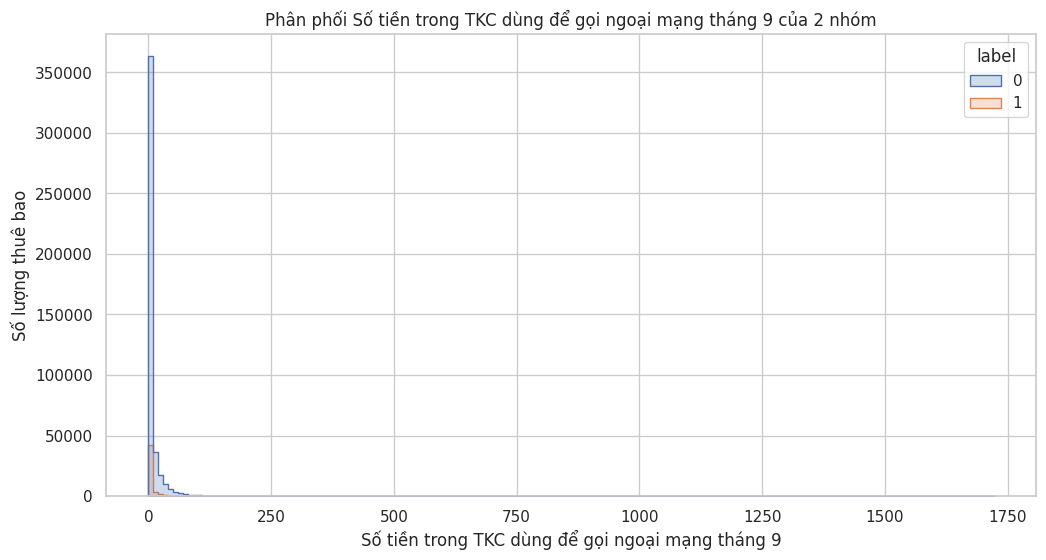

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

bin_width = 10 
num_bins = int((df['TKC_THOAI_OFFNET_T'].max() - df['TKC_THOAI_OFFNET_T'].min()) / bin_width)

sns.histplot(data=df, x='TKC_THOAI_OFFNET_T', hue='label', kde=False, element="step", stat="count", bins=num_bins, common_norm=False)

plt.title("Phân phối Số tiền trong TKC dùng để gọi ngoại mạng tháng 9 của 2 nhóm")
plt.xlabel("Số tiền trong TKC dùng để gọi ngoại mạng tháng 9")
plt.ylabel("Số lượng thuê bao")

# Show the plot
plt.show()

In [ ]:
result = (df['TKC_THOAI_OFFNET_T'] + df['TKC_THOAI_ONNET_T']) - df['TKC_THOAI_T']
df['result'] = (df['TKC_THOAI_OFFNET_T'] + df['TKC_THOAI_ONNET_T']) - df['TKC_THOAI_T']

positive_count = (result > 0).sum()

print("Number of positive rows:", positive_count)
df_positive = df[df['result'] > 0]  # Filter for positive results only


Number of positive rows: 18773


In [71]:
df_positive['result'].describe()

,result
count,1.877300e+04
mean,3.196079e-05
std,1.895985e-03
min,6.938894e-18
25%,8.881784e-16
50%,1.776357e-15
75%,3.552714e-15
max,1.500000e-01


In [ ]:
result  = (df['TKC_THOAI_OFFNET_T_1'] + df['TKC_THOAI_ONNET_T_1']) - df['TKC_THOAI_T_1']
df['result'] = (df['TKC_THOAI_OFFNET_T_1'] + df['TKC_THOAI_ONNET_T_1']) - df['TKC_THOAI_T_1']
# Count the number of positive values
positive_count = (result > 0).sum()

# Display the count of positive rows
print("Number of positive rows:", positive_count)
df_positive = df[df['result'] > 0]  # Filter for positive results only


Number of positive rows: 18782


In [74]:
df_positive['result'].describe()

,result
count,1.878200e+04
mean,4.392503e-05
std,1.972722e-03
min,6.938894e-18
25%,8.881784e-16
50%,1.776357e-15
75%,3.552714e-15
max,1.500000e-01


In [ ]:
result = (df['TKC_THOAI_OFFNET_T_2'] + df['TKC_THOAI_ONNET_T_2']) - df['TKC_THOAI_T_2']
df['result'] = (df['TKC_THOAI_OFFNET_T_2'] + df['TKC_THOAI_ONNET_T_2']) - df['TKC_THOAI_T_2']
positive_count = (result > 0).sum()

print("Number of positive rows:", positive_count)
df_positive = df[df['result'] > 0]  # Filter for positive results only

Number of positive rows: 18429


In [76]:
df_positive['result'].describe()

,result
count,1.842900e+04
mean,2.395127e-02
std,1.307974e+00
min,2.775558e-17
25%,8.881784e-16
50%,1.776357e-15
75%,3.552714e-15
max,1.033333e+02


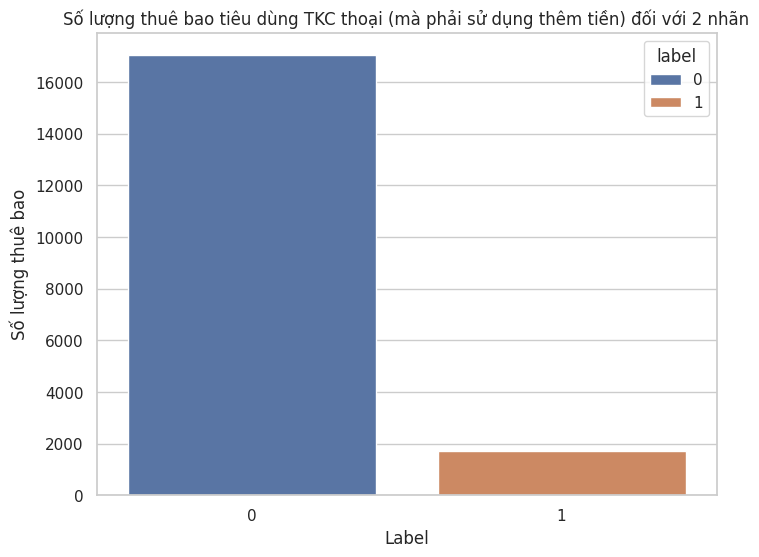

In [ ]:
df['result'] = (df['TKC_THOAI_OFFNET_T'] + df['TKC_THOAI_ONNET_T']) - df['TKC_THOAI_T']
df_positive = df[df['result'] > 0] 

plt.figure(figsize=(8, 6))
sns.countplot(data=df_positive, x='label', hue='label')

plt.title("Số lượng thuê bao tiêu dùng TKC thoại (mà phải sử dụng thêm tiền) đối với 2 nhãn")
plt.xlabel("Label")
plt.ylabel("Số lượng thuê bao")
plt.show()

In [59]:
df_positive

,ACCS_MTHD_KEY,ACTVTN_DT,ACC,SIM_TYPE,TRANG_THAI,PROVINCE_CODE,PBH,GEO_CITY_NAME,GEO_CNTY_NAME,CD_2G,...,gender,service_fee_expiry_date,super_period_expiry_date,account_disconnection_date,label,interval_tolock,interval_topay,interval_tocancel,interval_activate,result
8,79bb9a03da41a27e310be9eeecd80fd3dd0b5721,2021-04-08,1.216000e+09,4G,Danghoatdong2chieu,KGG,PBH U MINH THƯỢNG,Huyện U Minh Thượng,Vĩnh Hòa,0,...,female,2024-11-08,2024-10-29,2024-12-08,1,28,38,68,1272,1.776357e-15
114,7ceac40b6e0039c48c535323e8c86c031afd278f,2017-11-16,6.917000e+09,4G,Danghoatdong2chieu,TNN,Phòng BHKV PYN,Thị xã Phổ Yên,Phường Đồng Tiến,0,...,female,2024-11-07,2024-10-28,2024-12-07,0,27,37,67,2511,4.440892e-16
148,03a3602887ee2565c972f71890f1f75c771e792d,2021-02-02,0.000000e+00,4G,Danghoatdong2chieu,BTN,Phòng Bán hàng 1 - Địa bàn Hàm Thuận Bắc,Huyện Hàm Thuận Bắc,Xã Hàm Đức,0,...,female,2024-11-08,2024-10-29,2024-12-08,1,28,38,68,1337,1.776357e-15
179,527b2784964de9b795b5e948082fc4309fb7a743,2024-07-07,1.116001e+09,4G,Danghoatdong2chieu,BDG,Tổ QL Địa Bàn - BHTT DTG,Huyện Dầu Tiếng,Xã Thanh Tuyền,0,...,female,2024-11-08,2024-10-29,2024-12-08,1,28,38,68,86,2.220446e-16
201,45875f6a8a3788d254d13428d185d0d9c85bfee3,2022-11-09,6.922280e+09,4G,Danghoatdong2chieu,HGG,PBH Quản Bạ,Huyện Quản Bạ,Xã Tả Ván,0,...,female,2024-11-07,2024-10-28,2024-12-07,0,27,37,67,692,1.421085e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499840,58e32d3499fef2dc9d62c2a3b93020c55be4d881,2006-01-25,0.000000e+00,2G-3G,Danghoatdong2chieu,NAN,Phòng Bán Hàng Quỳnh Lưu,Huyện Quỳnh Lưu,Xã Quỳnh Mỹ,0,...,male,2027-04-02,2027-03-23,2027-05-02,0,903,913,943,6824,3.552714e-15
499902,e19cd62463769198da9bd51aa953ad29c4dc53f7,2016-10-26,1.115650e+09,2G-3G,Danghoatdong2chieu,GLI,Phòng Bán Hàng Đức Cơ - Chư Prông,Huyện Đức Cơ,Xã Ia Kla,0,...,male,2024-11-07,2024-10-28,2024-12-07,0,27,37,67,2897,2.220446e-16
499920,dc23c307c0cb626c827845850c570cdcc293959c,2015-10-27,9.010000e+02,2G-3G,Danghoatdong2chieu,HNI,Tổ BH Chương Mỹ 1,Huyện Chương Mỹ,Xã Thụy Hương,0,...,male,2024-11-08,2024-10-29,2024-12-08,0,28,38,68,3262,8.881784e-16
499955,97d282d8278d98534fbe8f08f167895641eb0516,2017-12-09,1.216000e+09,4G,Danghoatdong2chieu,THA,PBH Thọ Xuân - Thường Xuân,Huyện Thường Xuân,Thị trấn Thường Xuân,1,...,male,2025-07-27,2025-07-17,2025-08-26,0,289,299,329,2488,1.421085e-14


In [61]:
df_positive['result'].describe()

,result
count,1.877300e+04
mean,3.196079e-05
std,1.895985e-03
min,6.938894e-18
25%,8.881784e-16
50%,1.776357e-15
75%,3.552714e-15
max,1.500000e-01


In [57]:
df['result'].describe()

,result
count,497282.000000
mean,-2.290714
std,21.114450
min,-7518.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.150000


## 4. Đặc trưng liên quan đến lưu lượng

## 4.1 LL_DATA_T